In [1]:
sessionInfo()

R version 4.0.2 (2020-06-22)
Platform: x86_64-apple-darwin17.0 (64-bit)
Running under: macOS Catalina 10.15.7

Matrix products: default
BLAS:   /Library/Frameworks/R.framework/Versions/4.0/Resources/lib/libRblas.dylib
LAPACK: /Library/Frameworks/R.framework/Versions/4.0/Resources/lib/libRlapack.dylib

locale:
[1] en_US.UTF-8/en_US.UTF-8/en_US.UTF-8/C/en_US.UTF-8/en_US.UTF-8

attached base packages:
[1] stats     graphics  grDevices utils     datasets  methods   base     

loaded via a namespace (and not attached):
 [1] compiler_4.0.2  ellipsis_0.3.1  IRdisplay_0.7.0 pbdZMQ_0.3-3   
 [5] tools_4.0.2     htmltools_0.5.0 pillar_1.4.6    base64enc_0.1-3
 [9] crayon_1.3.4    uuid_0.1-4      IRkernel_1.1.1  jsonlite_1.7.1 
[13] digest_0.6.25   lifecycle_0.2.0 repr_1.1.0      rlang_0.4.7    
[17] evaluate_0.15  

In [2]:
library(plot3D)
library(ggplot2)
#library(magick)
library(animation)

# Random number generation

## Uniform random number generation

### Goal

To generate $U_i \stackrel{iid}{\sim} \text{unif}(0, 1)$.

* Basis for all other random number generation
* **Fact: NO RANDOM NUMBER IN COMPUTER** --- only look random (PSEUDO-RANDOM)

### Congruential generator

\begin{align*}
    x_{i+1} &= a x_i \mod m, \quad i=1, 2, \dotsc \\
    u_i &= x_i / m.
\end{align*}

* Modulus $m$ is a large prime number.
* Multiplier $a$ is a positive integer between 2 and $m-1$.
* Map $f: x \mapsto ax \mod m$ maps $\{1, \dotsc, m-1\}$ onto itself and is one-to-one:
    - Suppose $x\in\{1, \dotsc, m-1\}$. Then $f(x) \neq 0$ since $a$ and $m$ are relatively prime hence $ax$ is not a multiple of $m$. Thus $f$ maps $\{1, , \dotsc, m-1\}$ to $\{1, , \dotsc, m-1\}$.
    - If $ay = ax \mod m$, then $a(y - x) = m k$ for some integer $k$. Since $a$ and $m$ are relatively prime,  $y - x = m l$ for some interger $l$. That is, $x = y \mod m$. Hence map $f$ is one-to-one.
    - Since $f$ maps $\{1, , \dotsc, m-1\}$ to $\{1, , \dotsc, m-1\}$ and one-to-one, $f$ is also onto.
    
* Note
\begin{align*}
    x_1 &= a x_0 \mod m \\
    x_2 &= a x_1 \mod m = a^2 x_0 \mod m \\
    x_3 &= a x_2 \mod m = a^3 x_0 \mod m \\
    & \vdots \\
    x_n &= a x_{n-1} \mod m = a^n x_0 \mod m
\end{align*}
Hence if $a^n = 1 \mod m$ for some $n$, then 
$$
    x_n = x_0 \mod m
$$
and the (pseudo)random number generator repeats the sequence. The number $n$ is called the **period** of the RNG, and $x_0$ is called the **seed**.
    

In [3]:
set.seed(2020)  # set 2020th seed; does not mean x_0 = 2020
runif(5)
set.seed(2020)  # same seed results in same "random" sequence
runif(5)

[1] 0.6469028 0.3942258 0.6185018 0.4768911 0.1360972

[1] 0.6469028 0.3942258 0.6185018 0.4768911 0.1360972

* Primitive root of unity
    - Fermat's little theorem: $a^{m} = a \mod m$.
    - Since $a$ is not divisible by $m$, we have $a^{m-1} = 1 \mod m$.
    - Thus the period $n$ satisfies $n \le m - 1$.
    - *Primitive* root of unity: $a$ such that $n = m - 1$
    - If $a$ is primitive, then $x_1, x_2, \dotsc, x_{m-1}$ is a permutation of $\{1, 2, \dotsc, m-1\}$.
    - For $m=2^{31} - 1$ (Mersenne prime), $a=7^5 = 16807$ is primitive, leading to the period of $2^{31} - 2$ = `2,147,483,646`. This RNG was used in early versions of MATLAB (up to v4).
    
Good RNGs should have long periods, and should give samples which appear to be drawn from a uniform distribution. If the size of the sample is much less than the period of the RNG, then the sample should appear random.

In [4]:
# returns a congruential generator with fixed $a$ and $m$
congruential_gen <- function(a, m, seed = 1) {
    # initial seed for g
    if (!hasArg(seed)) seed <- (as.numeric(Sys.time()) * 1000) %% m
    g <- function(n) {
        u <- vector(length=n)
        u[1] <- seed
        for (i in seq_len(n-1)) {
            u[i+1] <- (a * u[i]) %% m
        }    
        seed <<- (a * seed) %% m  # seed update
        u / m        
    }
    g
}

### Autocorrelation

* Ideally, a pseudorandom number sequence should look i.i.d. If we take the first $p$ values to form an $p$-dimensional vector, the second $p$ values to form a second $p$-dimensional vector, etc, then these vectors should fill the $p$-dimensional hypercube uniformly.

* However, by construction the sequence generated by congruential generators depends on the previous value, hence tends to be correlated.

* It is known that congruential generators tend to give $p$-dimensional vectors that concentrate lower-dimensional hyperplanes, for some $p$.

In [5]:
# IBM System/360 RANDU generator
# a = 2^16 + 3 = 65539
# m = 2^31
RANDU <- congruential_gen(65539, 2^31) #, seed=1)

In [6]:
RANDU(10)

[1] 0.42772243 0.50002995 0.46268960 0.21336805 0.92850193 0.08819917
 [7] 0.48517760 0.05477311 0.77454022 0.59178340

In [7]:
n <- c(10, 50, 100, 500, 1000, 2000, 5000, 10000, 20000)

saveGIF({
  for (i in 1:length(n)) {
    u <- RANDU(n[i])
    x <- u[1:(n[i]-2)]
    y <- u[2:(n[i]-1)]
    z <- u[3:(n[i])]
    scatter3D(x, y, z, colvar = NULL, pch=20, cex = 0.5, theta=160, main = paste('n = ', n[i]))
  }
}, movie.name = 'RANDU.gif')

Output at: RANDU.gif



[1] TRUE

<img src="./RANDU.gif" width="500" align="left">

In [8]:
# Early MATLAB RNG
# a = 7^5
# m = 2^31 - 1
MATLABRNG <- congruential_gen(7^5, 2^31 - 1)

In [9]:
MATLABRNG(10)

[1] 0.4277232 0.7445680 0.9535758 0.7485405 0.7195620 0.6791599 0.6405343
 [8] 0.4598921 0.4069205 0.1133471

In [10]:
saveGIF({
  for (i in 1:length(n)) {
    u <- MATLABRNG(n[i])
    x <- u[1:(n[i]-2)]
    y <- u[2:(n[i]-1)]
    z <- u[3:(n[i])]
    scatter3D(x, y, z, colvar = NULL, pch=20, cex = 0.5, theta=160, main = paste('n = ', n[i]))
  }
}, movie.name = 'MATLABRNG.gif')

Output at: MATLABRNG.gif



[1] TRUE

<img src="./MATLABRNG.gif" width="500" align="left">

A simple modification is to introduce *shuffling* in the sequence, which we won't cover in detail.

### R's RNG

* R uses the Mersenne-Twister as the default RNG. This RNG was developed by Matsumoto and Nishimura in 1998, and is the first algorithm whose period ($2^{19937} - 1$) exceeds the number of electron spin changes since the creation of the Universe ($10^{6000}$ against $10^{120}$)!

* Mersenne-Twister guarantees 623 consecutive dimensions to be equidistributed (over the whole period). 

In [11]:
RNGkind()

[1] "Mersenne-Twister" "Inversion"        "Rejection"

## Transformation methods

From now on, we assume the the problem of generating uniform random numbers has been solved for practical purposes.

### Inverse CDF method

For a random variable $X$, let $F$ be its cumulative distribution function (CDF), that is, $F(x) = P(X \le x)$.
Recall that $F$ is right-continuous and nondecreasing. Also, if $F$ is strictrly increasing, random variable $F(X)$ is uniformly distributed on $[0, 1]$. Below, we generalize this result.

The inverse CDF of $X$ is defined as
$$
    F^{-1}(u) = \inf\{x: F(x) \ge u\}, \quad 0 < u < 1
    ,
$$
which coincides with the usual inverse of $F$ if $F$ is strictly increasing.

**Proposition 1**. Let $X$ be a random variable with CDF $F$. Then the following holds.
1. If $F$ is continuous, then $U = F(X)$ is a uniform random variable on $[0, 1]$.
2. If $F$ is not continous, then $P[F(X) \le y] \le y$ for all $y \in [0, 1]$.
3. If $U$ is uniform on $[0, 1]$, then $F^{-1}(U)$ has CDF $F$.
    
*Proof*. 
* Part 1: We will show that 
$$
    P[F(X) \le F(t)] = F(t)
    \tag{*}
$$
for any $t$. Suppose for now this is true. 
\
\
Let $u \in (0, 1)$. Then by continuity of $F$, there is $y$ such that $F(y) = u$. By (*), 
$$
    P[F(X) \le u] = P[F(X) \le F(y)] = F(y) = u.
$$

* Part 3: It suffices to show that $\{F^{-1}(U) \le t\} = \{U \le F(t)\}$. If $F^{-1}(u)=\inf\{x: F(x) \ge u\} \le t$, then by the monotonicity and right-continuity of $F$, the set $\{x: F(x) \ge u\}$ is an half-closed interval containing its left endpoint, which is $F^{-1}(u)$. Hence $F(F^{-1}(u)) \ge u$. Since $F^{-1}(u) \le t$, again by monotonicity of $F$, it follows that $u \le F(F^{-1}(u)) \le F(t)$. Conversely, if $u \le F(t)$, then by definition $F^{-1}(u) \le t$.

* Part 2: by part 3, $X\stackrel{d}{=}F^{-1}(U)$, where $U$ is uniform on $[0, 1]$. Since $x=F^{-1}(u)$ implies $u \le F(x)$, it follows from $X\stackrel{d}{=}F^{-1}(U)$ that $U \le F(X)$ almost surely. Then,
$\{F(X) \leq y \} \subset \{U \leq y\}$. Therefore,
$$
    P[F(X) \le y] \le P(U \le y) = y.
$$

* It remains to show (*). Monotonicity of $F$ yields $\{X > t\} \subset \{F(X) \ge F(t)\}$. Hence $\{X > t \} \cap \{F(X) < F(t) \} = \emptyset$. Likewise $\{X \le t\} \cap \{F(X) > F(t)\} = \emptyset$. Then,
\begin{align*}
    \{X > t\} \cap \{F(X) \le F(t)\} &=
    [\{X > t\} \cap \{F(X) < F(t) \}] \cup [\{X > t\} \cap \{F(X) = F(t)\}] \\
    &= \{X > t\} \cap \{F(X) = F(t)\}
    \\
    \{X \le t\} \cap \{F(X) \le F(t)\} &= \{X \le t\} \cap \{F(X) > F(t)\}^c 
    = \{X \le t\}
\end{align*}
So,
$$
    \{F(X) \le F(t) \}  = \{X \le t\} \cup [\{X > t\} \cap \{F(X) = F(t)\}] =: A \cup B
    .
$$
Obviously events $A$ and $B$ are disjoint. However, event $B$ corresponds to the values $x$ of $X$ with which $F(x)$ is constant. Hence $P(B)=\int_B dF(x) = 0$. Therefore,
$$
    P[F(X) \le F(t)] = P(A) + P(B) = P(A) = P(X \le t) = F(t).
$$

#### Exponential distribution

* CDF $F(x) = 1 - e^{-\lambda x}$ yields $F^{-1}(u) = -\frac{1}{\lambda}\log u$ on $(0, 1)$. 

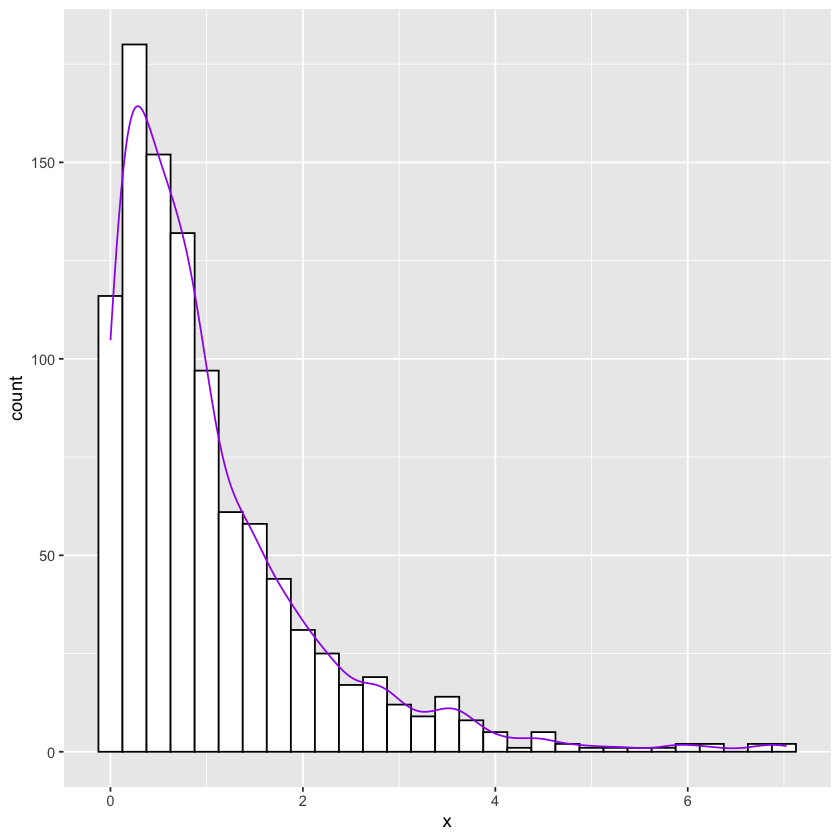

In [12]:
# Exp(1)
n <- 1000
u <- runif(n)
x <- -log(u)
expdata <- data.frame(x)
plt <- ggplot(expdata, aes(x=x)) +  
    geom_histogram(binwidth=0.25, fill="white", color="black") + 
    geom_density(aes(y=0.25 * ..count..), color="purple")
print(plt)

#### Cauchy distribution

From the density of the Cauchy distribution
$$
    f(x) = \frac{\beta}{\pi(\beta^2 + (x-\mu)^2)},
$$
its CDF is $F(x) = \frac{1}{2} + \frac{1}{\pi}\tan^{-1}\left(\frac{x-\mu}{\beta}\right)$. Thus
$$
    F^{-1}(u) = \mu + \beta\tan(\pi u - \pi/2) = \mu - \frac{\beta}{\tan(\pi u)}
    .
$$

Warning message:
“Removed 4 rows containing non-finite values (stat_bin).”
Warning message:
“Removed 4 rows containing non-finite values (stat_density).”
Warning message:
“Removed 2 rows containing missing values (geom_bar).”


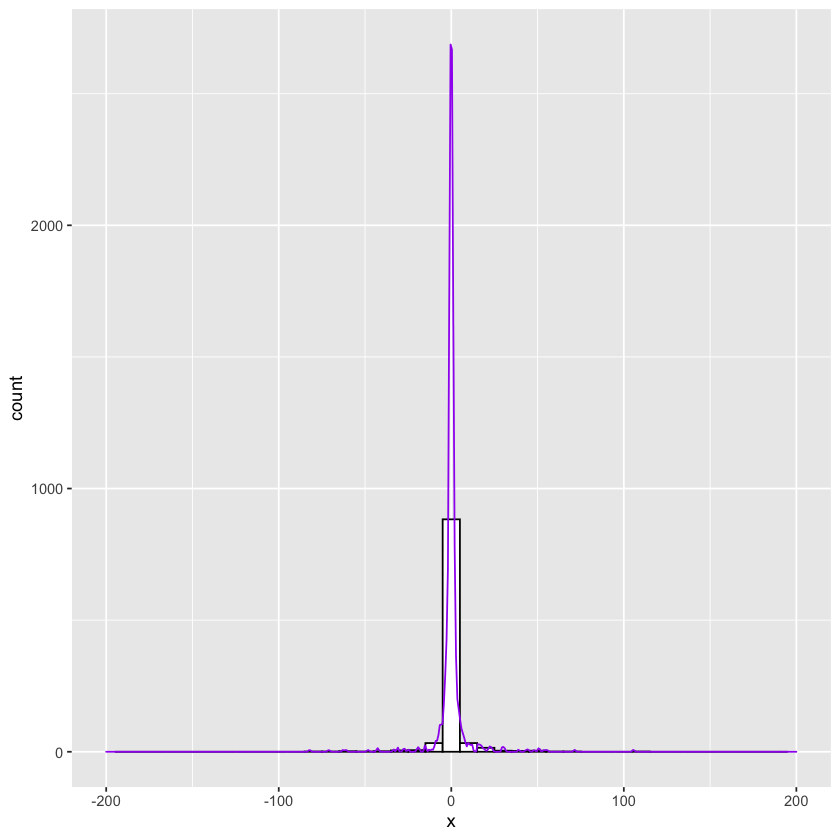

In [13]:
# standard Cauchy (beta=1, mu=0)
n <- 1000
u <- runif(n)
x <- -1/tan(pi * u)
#hist(x, breaks=40)
cauchydata <- data.frame(x)
plt <- ggplot(cauchydata, aes(x=x)) +  
    geom_histogram(binwidth=10, fill="white", color="black") + 
    geom_density(aes(y=10 * ..count..), color="purple") + 
    xlim(-200, 200)
print(plt)

#### Discrete uniform distribution 

$X \sim \text{unif}(\{1, 2, \dotsc, k\})$. It is easy to verify $F(x) = \frac{1}{k}\lfloor x \rfloor$ for $x \in [0, n]$ and $F^{-1}(u)=\lceil ku \rceil$.


In [14]:
k <- 10
n <- 1000
u <- runif(n)
x <- ceiling(k * u)
table(x)

x
  1   2   3   4   5   6   7   8   9  10 
108 108  92  93  97  85  94 118 108  97 

#### Geometric distribution 

If $X \sim \text{geom}(p)$, then its probability mass functin $p(x) = (1-p)^{x-1}p$.

For $Y \sim \text{Exp}(\lambda)$, 
\begin{align*}
    P(\lceil Y \rceil = k) &= P(k-1 < Y \le k) = F_Y(k) - F_Y(k-1) = (1 - e^{-\lambda k}) - (1 - e^{-\lambda(k-1)}) \\
   &=  e^{-\lambda(k-1)}(1 - e^{-\lambda}) \\
   &= (1 - p)^{k-1} p
\end{align*}
if $\lambda$ satisfies $p = 1 - e^{-\lambda}$, or $\lambda = -\log(1-p)$.

For this $\lambda$, $X = \lceil Y \rceil = \lceil -\frac{1}{\lambda}\log U \rceil = \lceil \frac{\log U}{\log(1-p)}\rceil$.

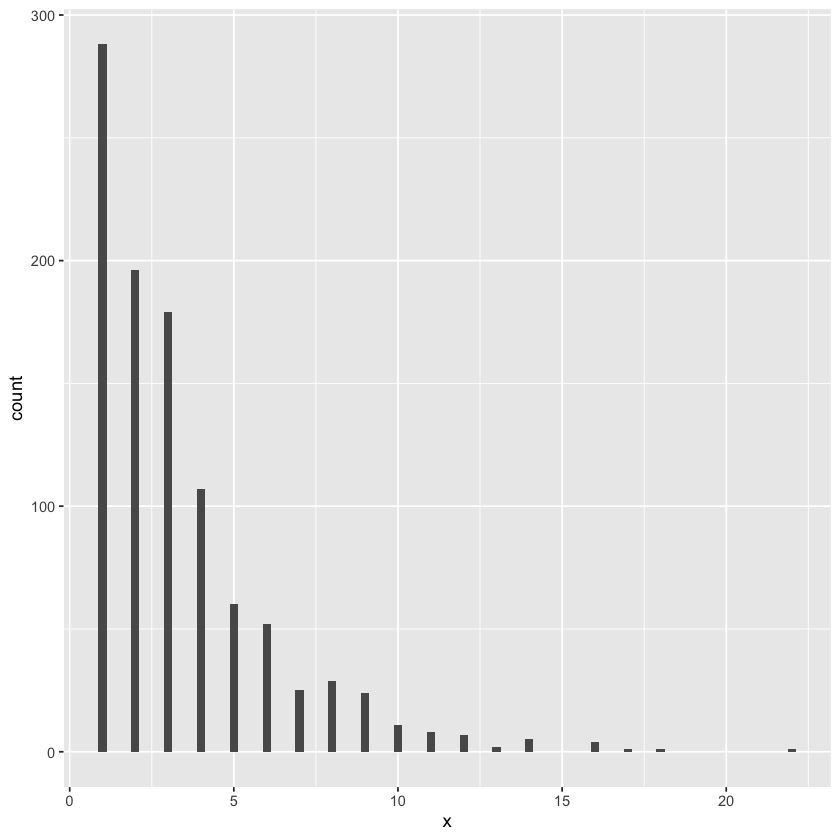

In [15]:
gengeom <- function(p, nsamp=1) {
    u <- runif(nsamp)
    y <- log(u) / log(1 - p)
    ceiling(y)
}    
nsamp <- 1000
p <- 0.3
x <- gengeom(p, nsamp)
geomdata <- data.frame(x)
plt <- ggplot(geomdata, aes(x=x)) + geom_histogram(binwidth=0.25)
print(plt)

### Normal random numbers

For $X \sim N(0, 1)$, inverse CDF $\Phi^{-1}$ does not have a closed form.

#### Box-Muller

Generates $X, Y \stackrel{iid}{\sim} N(0, 1)$.

Transforms the random Cartesian coordinates $(X, Y)$ to polar coorinates $(R, \Theta)$. Since $(X, Y)=(R\cos\Theta, R\sin\Theta)$,
$$
    \iint_A f_{XY}(x, y)dxdy = \iint_A \frac{1}{2\pi}\exp\left(-\frac{x^2 + y^2}{2}\right)dxdy
    = \iint_A \frac{1}{2\pi}\exp\left(-\frac{r^2}{2}\right)rdrd\theta
    .
$$

Hence $R$ has density $f_R(r) = r\exp(-\frac{r^2}{2})$ and $\Theta$ is uninform on $[0, 2\pi]$. Since
$$
    P(R > \rho) = P(R^2 > \rho^2) = \int_\rho^{\infty} r\exp\left(-\frac{r^2}{2}\right)dr = \exp\left(-\frac{1}{2}\rho^2\right),
$$
random variable $R^2$ is exponentially distributed with $\lambda = 1/2$.

Thus for independent $U, V \sim \text{unif}(0, 1)$, set
$$
    R = (-2\log U)^{1/2}, \quad \Theta = 2\pi V
    .
$$
Then $(X, Y) = (R\cos\Theta, R\sin\Theta)$ are independently $N(0, 1)$.

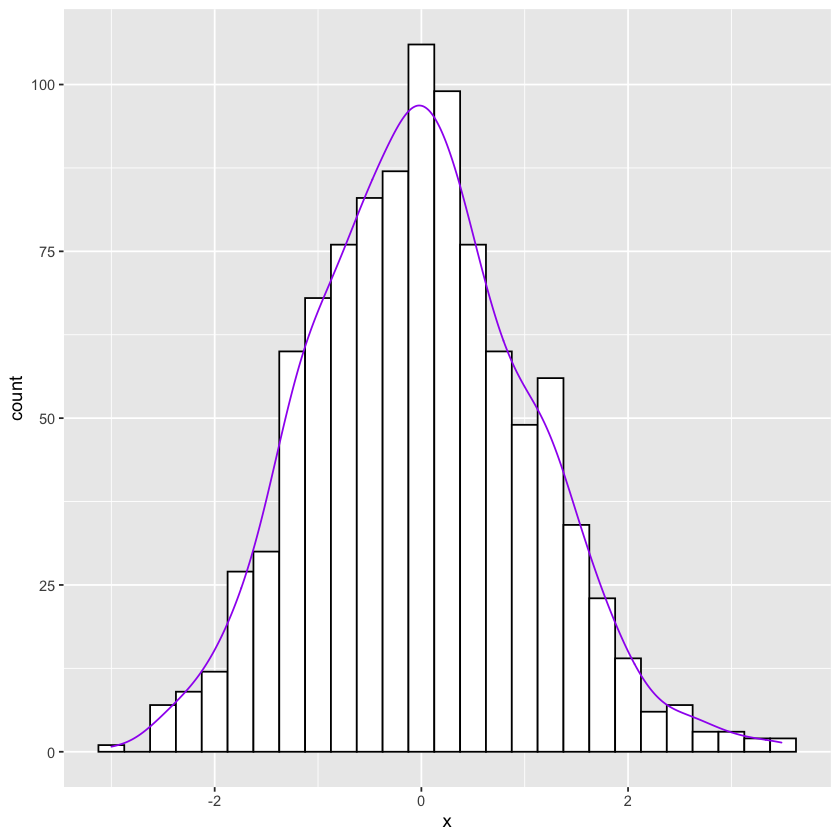

In [16]:
boxmuller <- function(nsamp) {
    n <- ceiling(nsamp / 2)
    u <- runif(n)
    v <- runif(n)
    r <- sqrt(-2 * log(u))
    theta <- 2 * pi * v
    x <- r * cos(theta)
    y <- r * sin(theta)
    samp <- c(x, y)
    samp[seq_len(nsamp)]
}
#hist(c(x, y))
n <- 1000
normdata1 <- data.frame(x = boxmuller(n))
plt <- ggplot(normdata1, aes(x=x)) +  
    geom_histogram(binwidth=0.25, fill="white", color="black") + 
    geom_density(aes(y=0.25 * ..count..), color="purple")
print(plt)

#### Marsaglia

* From the Box-Muller transformation, we learned that if $R^2 \sim \text{Exp}(1/2)$ and $\Theta\sim\text{unif}(0, 2\pi)$ and they are independent, $(R\cos\Theta, R\sin\Theta)$ are i.i.d. standard normal. 

* On the other hand, if a random point $(U, V)$ is uniformly distributed on the unit disk, and let $(U, V) = (T\cos\Phi, T\sin\Phi)$, then
$$
    P(T^2 \le t^2, 0 \le \Phi \le \phi) = 
    \frac{t^2\phi}{2\pi}, \quad t^2 \le 1, ~ \phi \in (0, 2\pi) \\
$$
which means that $T^2 = U^2 + V^2 \sim \text{unif}(0, 1)$, $\Phi \sim \text{unif}(0, 2\pi)$, and they are independent.

* Therefore, if we sample $(U, V)$ uniformly from the unit disk, and set $T = \sqrt{U^2 + V^2}$, $\cos\Phi = U/T$, $\sin\Phi=V/T$, then $T^2\sim\text{unif}(0,1)$ and $-2\log T^2$ is identically distributed to $R^2$, i.e., $\text{Exp}(1/2)$, and $\Phi$ is identically distributed to $\Theta$, i.e., uniform on $(0, 2\pi)$. Therefore, if we set $(X, Y)$ such that
$$
    X = \sqrt{-2\log T^2}\frac{U}{T},
    \quad
    Y = \sqrt{-2\log T^2}\frac{V}{T},
$$
then $X, Y$ are i.i.d. standard normal.

* One way to sample from the unit disk is to sample $(U, V)$ from $\text{unif}[-1, 1]\times\text{unif}[-1, 1]$, and discard the sample if $U^2 + V^2 > 1$ and resample (see acceptance-rejection sampling below).

* Algorithm:
    1. $U, V \stackrel{iid}{\sim} \text{unif}[-1, 1]$;
    2. If $T = \sqrt{U^2 + V^2} > 1$, go to 1;
    3. Set $X = \sqrt{-2\log T^2}\frac{U}{T}$ and $Y = \sqrt{-2\log T^2}\frac{V}{T}$.
    
* This method avoids the trigonometric function evaluations of the Box-Muller, but uses $4/\pi$ as many random pairs on average.

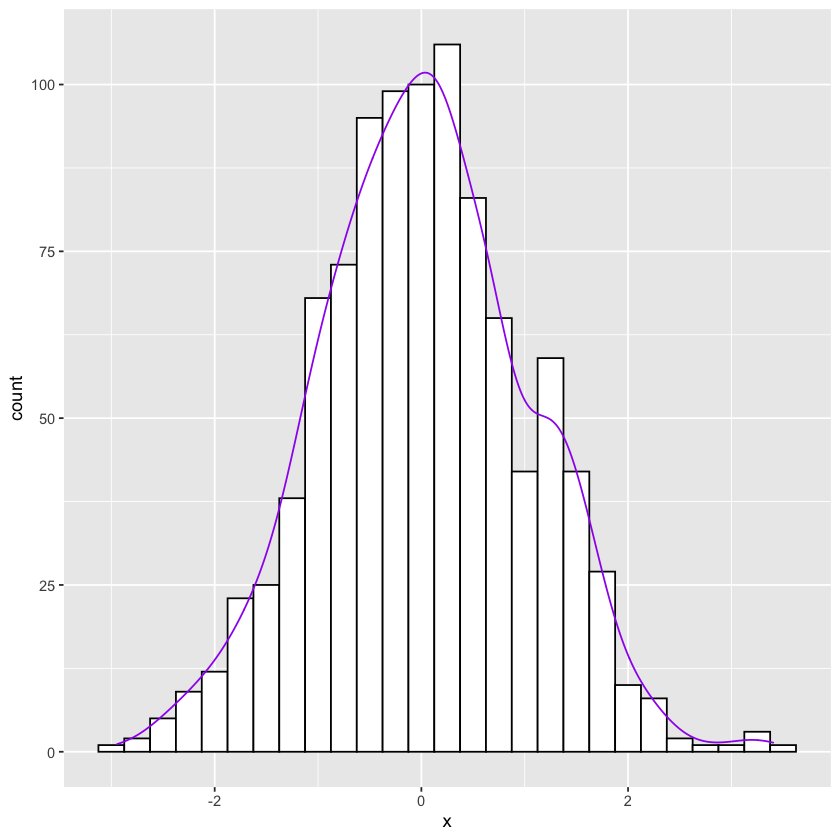

In [17]:
marsaglia <- function(nsamp) {
    n <- ceiling(nsamp / 2)
    it <- 0
    x <- numeric(n)
    y <- numeric(n)
    while (it < n) {
        u <- 2 * runif(1) - 1
        v <- 2 * runif(1) - 1
        tau <- sqrt(u^2 + v^2)
        if (tau > 1) next
        x[it] <- sqrt(-4 * log(tau)) * u / tau
        y[it] <- sqrt(-4 * log(tau)) * v / tau
        it <- it + 1
    }
    samp <- c(x, y)
    samp[seq_len(nsamp)]    
}
n <- 1000
normdata2 <- data.frame(x = marsaglia(n))
plt <- ggplot(normdata2, aes(x=x)) +  
    geom_histogram(binwidth=0.25, fill="white", color="black") + 
    geom_density(aes(y=0.25 * ..count..), color="purple")
print(plt)

## Random numbers by definition

### Bernoulli

1. Set the success probability $p$
2. Generate $U \sim \text{unif}(0, 1)$.
3. Let $X = \mathbb{I}_{\{U \le p\}}$.
4. Then $X \sim \text{Ber}(p)$.

### Binomial

1. Set the success probability $p$
2. Generate $n$ independent $X_i \sim \text{Ber}(p)$.
3. Let $X_n = \sum_{i=1}^n X_i$.
4. Then $X_n \sim B(n, p)$.

### Negative binomial

1. Set the success probability $p$
2. Generate $r$ independent $X_i \sim \text{Geom}(p)$.
3. Let $X_r = \sum_{i=1}^r X_i$.
4. Then $X_r \sim \text{NegBin}(r, p)$.

### Poisson

1. Generate $U_i \stackrel{iid}{\sim} \text{unif}(0, 1)$.
2. Find $N$ such that $\prod_{i=1}^N U_i \ge e^{-\lambda} > \prod_{i=1}^{N+1} U_i$.
3. Then $N \sim \text{Poi}(\lambda)$.

- This is because $T_i = -\frac{1}{\lambda}\log U_i \stackrel{iid}{\sim} \text{Exp}(\lambda)$,
and is the waiting time between the $i-1$st and the $i$th event of the Poisson counting process $N(t) \sim \text{Poi}(\lambda t)$.
- That is, $N \sim \text{Poi}(\lambda) \iff T_1 + \dotsb + T_N \le 1 < T_1 + \dotsb + T_N + T_{N+1}$.

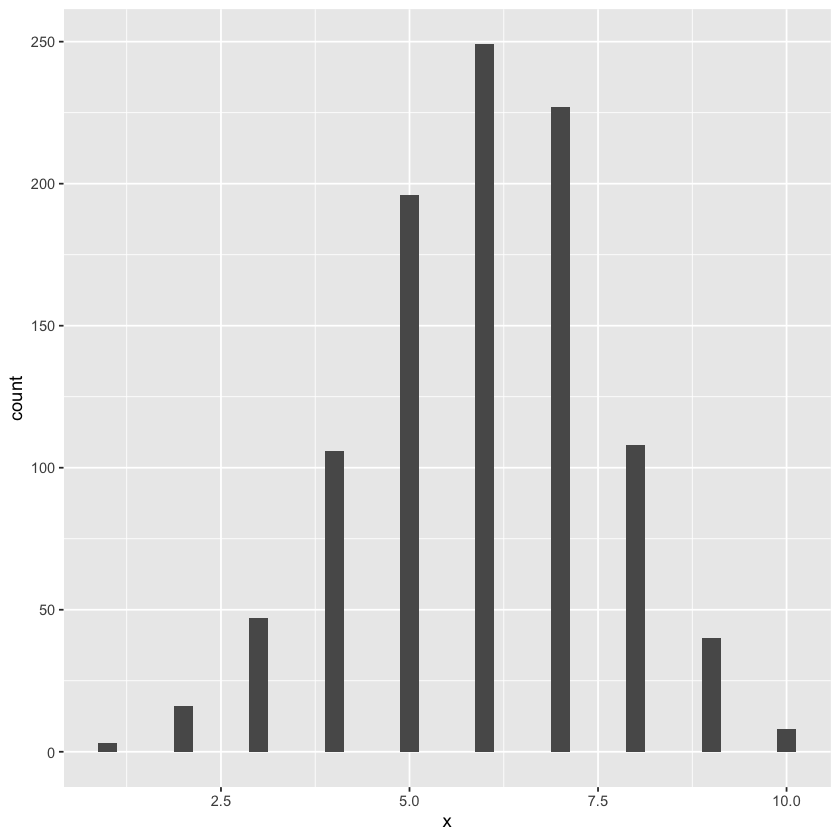

In [18]:
## Binomial random number generation
genbin <- function(n, p) {
    u <- runif(n)
    x <- sum(u < p)
}
n <- 10; p <- 0.6
nsamp <- 1000
x <- numeric(nsamp)
for (i in seq_len(nsamp)) {
    x[i] <- genbin(n, p)
}
bindata <- data.frame(x)
plt <- ggplot(bindata, aes(x=x)) + geom_histogram(binwidth=0.25)
print(plt)

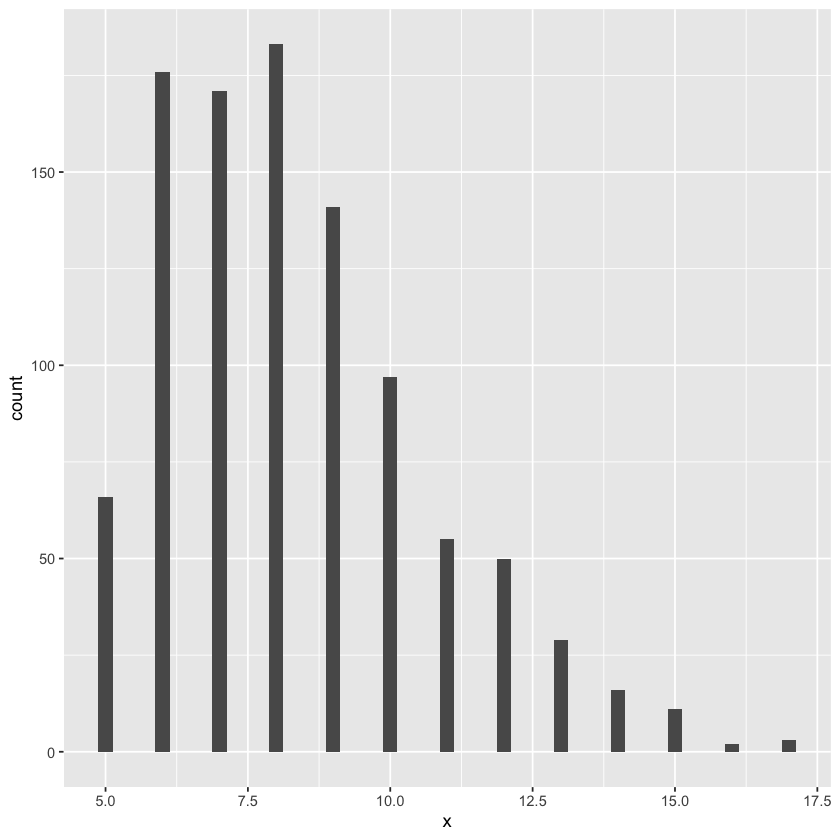

In [19]:
# Negative binomial random number generation
gengeom <- function(p, nsamp=1) {
    u <- runif(nsamp)
    y <- log(u) / log(1 - p)
    ceiling(y)
}    
nsamp <- 1000
p <- 0.6
r <- 5
x <- numeric(nsamp)
for (i in seq_len(r)) {
    x <- x + gengeom(p, nsamp)
}
negbindata <- data.frame(x)
plt <- ggplot(negbindata, aes(x=x)) + geom_histogram(binwidth=0.25)
print(plt)

In [1]:
# Poisson random number generation
genpoi <- function(lam, maxiter=1000) {
    u_cum <- 1.0
    k <- 0
    while (u_cum > exp(-lam) && k < maxiter ) {
        u <- runif(1)
        u_cum <- u_cum * u
        k <- k + 1
    }
    k - 1
}
lam <- 3  # Poisson rate
nsamp <- 1000
x <- numeric(nsamp)
for (i in seq_len(nsamp)) {
    x[i] <- genpoi(lam)
}
poidata <- data.frame(x)
plt <- ggplot(poidata, aes(x=x)) + geom_histogram(binwidth=0.25)
print(plt)

ERROR: Error in ggplot(poidata, aes(x = x)): could not find function "ggplot"


### Chi-square

1. Generate $Z_1, \dotsc, Z_{\nu} \stackrel{iid}{\sim} N(0, 1)$.
2. Let $X_{\nu} = \sum_{i=1}^{\nu} Z_i^2$.
3. Then $X_{\nu} \sim \chi^2(\nu)$.

Alternatively, for even $\nu$:

1. Generate $U_i \stackrel{iid}{\sim} \text{unif}(0, 1)$.
2. Let $X_{\nu} = -2\log(\prod_{i=1}^{\nu/2} U_i) = \sum_{i=1}^{\nu/2}(-2\log U_i)$.
3. Then $X_{\nu} \sim \chi^2(\nu)$.

This is because $\chi^2(\nu) = \text{Gamma}(\nu/2, 2)$, where 2 is the scale parameter.

### Student's $t$

1. Generate $Z \sim N(0, 1)$ and $X \sim \chi^2(\nu)$ independently.
2. Let $T = Z / \sqrt{X/\nu}$.
3. Then $T \sim t(\nu)$.

### $F$

1. Generate $X_1 \sim \chi^2(\nu_1)$ and $X_2 \sim \chi^2(\nu_2)$ independently.
2. Let $$F = \frac{X_1/\nu_1}{X_2/\nu_2}.$$
3. The $F \sim F(\nu_1, \nu_2)$.

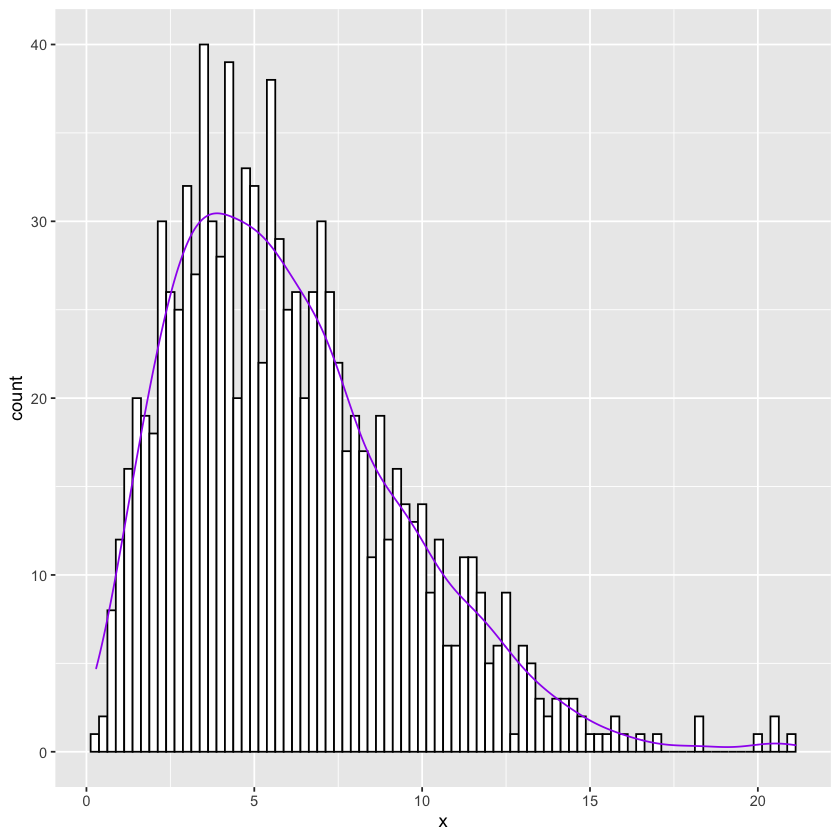

In [21]:
## chi-square random number generation
genchisq1 <- function(nsamp, nu) {
    z <- matrix(rnorm(nsamp * nu), nrow=nsamp)
    rowSums(z^2)
}
nu <- 6
n <- 1000
chisqdata1 <- data.frame(x = genchisq1(n, nu))
plt <- ggplot(chisqdata1, aes(x=x)) +  
    geom_histogram(binwidth=0.25, fill="white", color="black") + 
    geom_density(aes(y=0.25 * ..count..), color="purple")
print(plt)

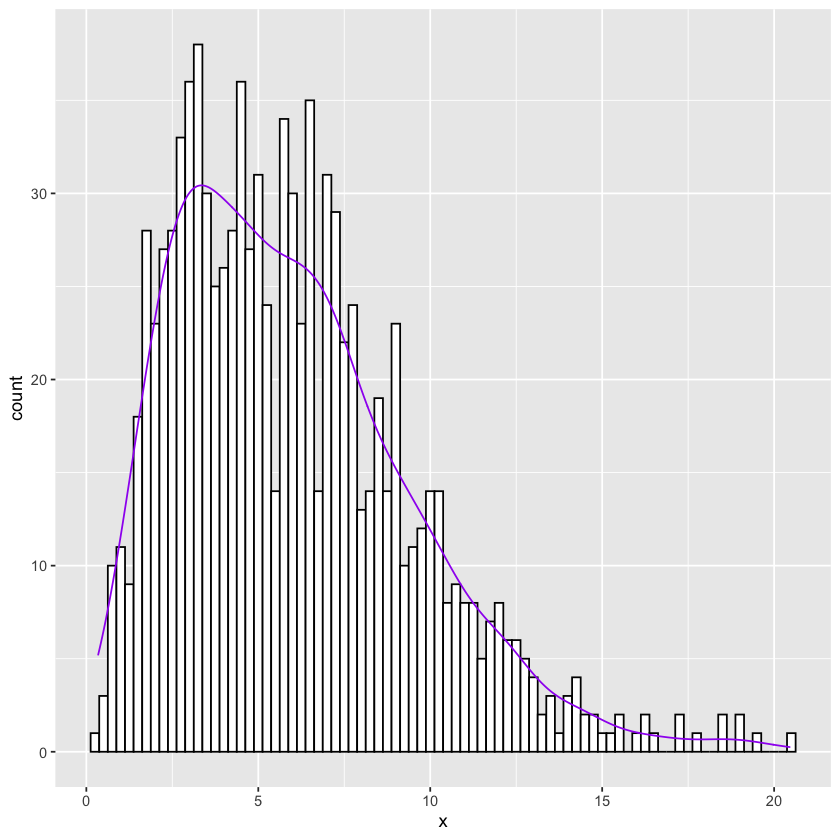

In [22]:
## chi-square random number generation 2
genchisq2 <- function(nsamp, nu) {
    u <- matrix(runif(nsamp * nu / 2), nrow=nsamp)
    -2 * log(apply(u, 1, prod) )
}
nu <- 6
n <- 1000
chisqdata2 <- data.frame(x = genchisq2(n, nu))
plt <- ggplot(chisqdata2, aes(x=x)) +  
    geom_histogram(binwidth=0.25, fill="white", color="black") + 
    geom_density(aes(y=0.25 * ..count..), color="purple")
print(plt)

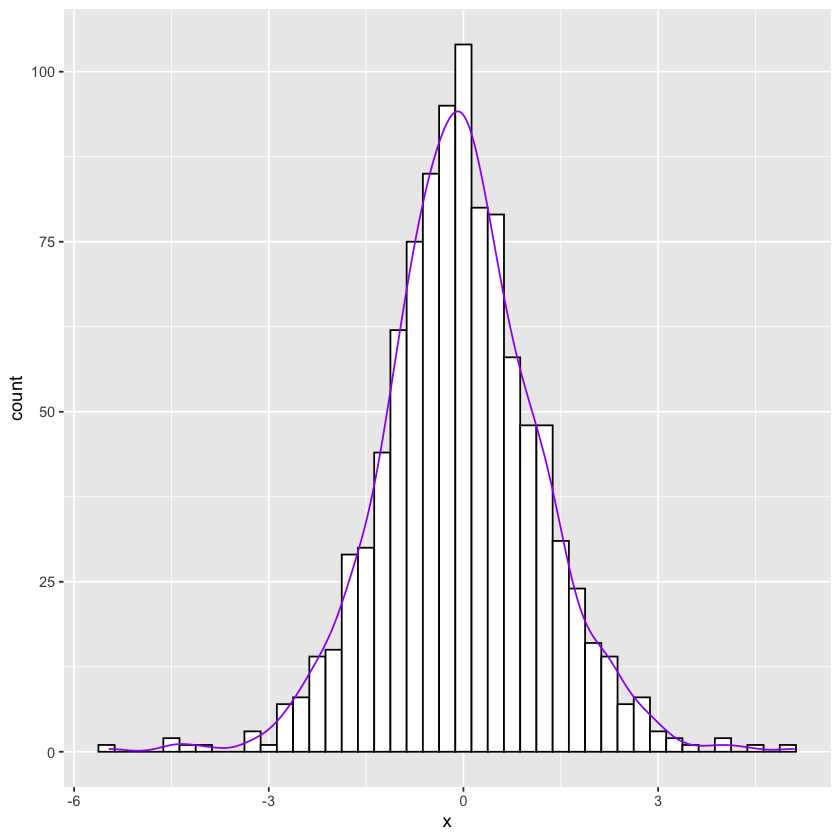

In [23]:
## Student's t random number generation
gent <- function(nsamp, nu) {
    z <- rnorm(nsamp)
    chisq <- genchisq1(nsamp, nu)
    trv <- z / sqrt(chisq / nu)
}
nu <- 6
n <- 1000
tdata <- data.frame(x = gent(n, nu))
plt <- ggplot(tdata, aes(x=x)) +  
    geom_histogram(binwidth=0.25, fill="white", color="black") + 
    geom_density(aes(y=0.25 * ..count..), color="purple")
print(plt)

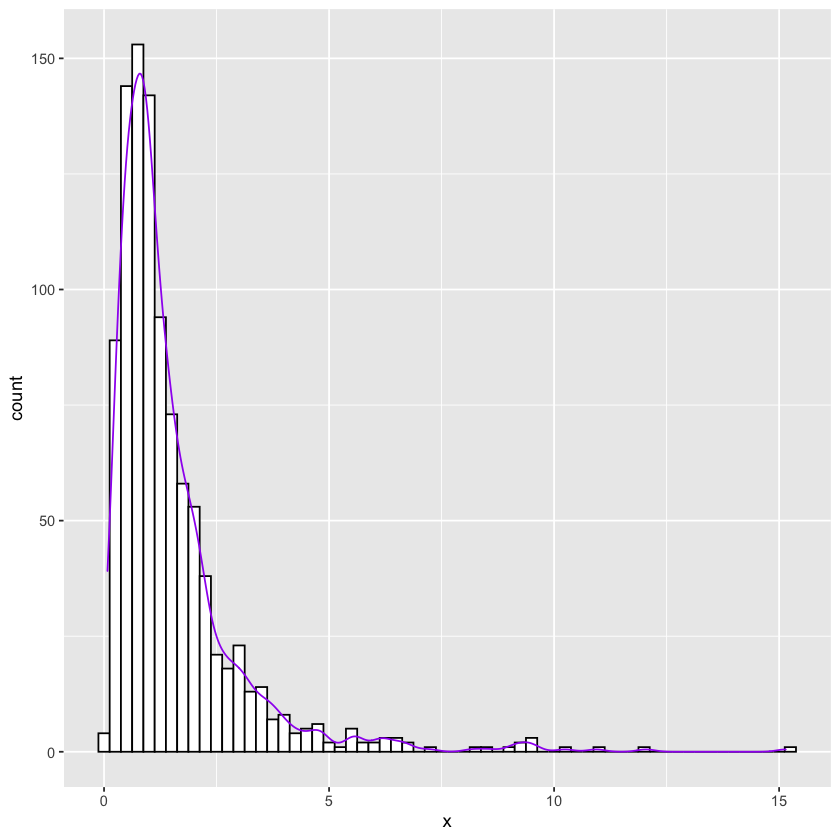

In [24]:
# F random number generation
genF <- function(nsamp, nu1, nu2) {
    chisq1 <- genchisq1(nsamp, nu1)
    chisq2 <- genchisq1(nsamp, nu2)
    Frv <- chisq1 / nu1 / chisq2 * nu2
}
nu1 <- 10; nu2 <- 6
n <- 1000
Fdata <- data.frame(x = genF(n, nu1, nu2))
plt <- ggplot(Fdata, aes(x=x)) +  
    geom_histogram(binwidth=0.25, fill="white", color="black") + 
    geom_density(aes(y=0.25 * ..count..), color="purple")
print(plt)

## Acceptance-rejection sampling

Suppose we want to sample from a distribution with complicated density $f(x)$. It is not easy to use the above method since neither the cdf nor its inverse is analytically available.

John von Neumann, while working on the Mahanttan Project, suggested the following:

1. Find the "envelope" of $f$, i.e., a simple density $g(x)$ such that 
$$
    f(x) \le c g(x) =: h(x)
$$
for all $x$, for some constant $c > 0$.

2. Sample a random variable $X$ distributed according to $g$. 

3. Accept $X$ as a representative of $f$ if
    - $U \le \displaystyle\frac{f(X)}{h(X)}$,
    - where $U$ is a uniform random variable on $[0, 1]$ drawn independently.
    
4. Reject $X$ otherwise. Go to Line 2.

### Why AR sampling works?

**Definition** (Body of a function). For a nonnegative, integrable function $f$, its body is defined and denoted by
$$
    B_f = \{(x, y): 0 \le y \le f(x) \}.
$$

- Thus the volume  $B_f$ is $|B_f| = \int_{-\infty}^{\infty}f(x)dx = \int_{-\infty}^{\infty}\int_0^{f(x)}1dydx$.

**Theorem 1**. Supose random variable $X$ has density $g$,  $U\sim\text{unif}[0, 1]$ is independent of $X$, and there exists $c > 0$ such that $f(x) \le c g(x)$ for all $x$. Then, the random vector $(X, cg(X)U)$ is uniformly distributed over the body $B_{cg}$ of $cg$.

- Theorem 1 states that the AR sampling scheme uniformly samples from $B_{cg}=B_h$.
- The sample is accepted if and only if $0 \le h(X)U = cg(X)U = Y \le f(X)$, i.e., $(X, Y) \in B_f$. The conditional density of $(X, Y)$ given $\{(X, Y) \in B_f\}$ is merely
$$
    \frac{|B_{cg}|^{-1}\mathbb{I}_{B_{cg}}(x,y)}{P(B_f)}\mathbb{I}_{B_f}(x,y)
    = \frac{|B_{cg}|^{-1}\mathbb{I}_{B_{cg}}(x,y)}{|B_f|/|B_{cg}|}\mathbb{I}_{B_f}(x,y)
    = \frac{1}{|B_f|}\mathbb{I}_{B_f}(x,y)
    .
$$
That is, $(X,Y)|\{(X, Y)\in B_f\} \sim \text{unif}(B_f)$.
    + This means the accepted sample $(X, Y)$ is drawn according to $\text{unif}(B_f)$.
- Now the marginal density of $X$ is $f$. To see this, note when $(X, Y) \sim \text{unif}(B_f)$,
\begin{align*}
    P(X \in A) &= \frac{|\bar{A}|}{|B_f|},
    \quad
    \bar{A} = B_f \cap \{(x, y): x\in A\} = \{(x, y): x \in A, ~ 0 \le y \le f(x)\}.
    \\
    &= \frac{\int_A f(x)dx}{1}, \quad \because |B_f| = \int_{-\infty}^{\infty}f(x)dx = 1
    \\
    &= \int_A f(x)dx.
\end{align*}

- Thus sample $X$ is drawn according to $f$!

- The total acceptance ratio is
\begin{align*}
    P\left(U \le \frac{f(X)}{cg(X)}\right) 
    &= \int_{-\infty}^{\infty}\int_{0}^{f(x)/[cg(x)]} 1\cdot g(x) du dx \\
    &= \int_{-\infty}^{\infty} g(x) \int_{0}^{f(x)/[cg(x)]} 1 du dx \\
    &= \int_{-\infty}^{\infty} g(x) \frac{f(x)}{cg(x)}  dx \\
    &= \int_{-\infty}^{\infty} \frac{f(x)}{c}dx \\
    &= \frac{1}{c} \int_{-\infty}^{\infty} f(x) dx \\
    &= \frac{1}{c}
    .
\end{align*}

#### Proof of Theorem 1

We want to show that the joint density of $(X, cg(X)U)$ is 
$$\frac{1}{|B_{cg}|}\mathbb{I}_{B_{cg}}(x, y).$$

Let $Y = cg(X)U$. Then $Y|\{X=x\}  \stackrel{d}{=} cg(x) U \sim \text{unif}[0, cg(x)]$. That is, the conditional density of $Y$ given $X$ is
$$
    p_{Y|X}(y|x) = \frac{1}{cg(x)}\mathbb{I}_{[0, cg(x)]}(y).
$$
By construction, the marginal density of $X$ is given by $p_X(x) = g(x)$. Therefore the joint density of $(X, Y)$ is
\begin{align*}
    p_{XY}(x, y) &= p_X(x)p_{Y|X}(y|x) = \frac{1}{c}\mathbb{I}_{[0, cg(x)]}(y) \\
    &= \begin{cases} 1/c, & \text{if } 0 \le y \le c g(x), \\
        0, & \text{otherwise}. \end{cases}
    \\
    &= \frac{1}{c}\mathbb{I}_{B_{cg}}(x,y).
\end{align*}
Now since
$$
    1 = \int_{-\infty}^{\infty}\int_0^{cg(x)}\frac{1}{c}dydx = \frac{1}{c}|B_{cg}|,
$$
we have
$\frac{1}{|B_{cg}|}\mathbb{I}_{B_{cg}}(x, y)$
as desired.

### Example: Marsaglia

> One way to sample from the unit disk is to sample $(U, V)$ from $\text{unif}[-1, 1]\times\text{unif}[-1, 1]$, and discard the sample if $U^2 + V^2 > 1$ and resample.

We have $X=(U, V)$.

* Target density: $f(u, v) = \frac{1}{\pi}\mathbb{I}_{\{u^2+v^2<1\}}(u, v)$ (uniform from unit disc)
* Sampling density: $g(u, v) = \frac{1}{4}\mathbb{I}_{\{|u|<1, |v|<1\}}(u, v)$ (uniform from $[-1, 1]^2$)
* Envelope: $h(u, v) = \frac{1}{\pi}\mathbb{I}_{|u|<1, |v|<1}(u, v) = \frac{4}{\pi}g(u, v)$, hence $c=4/\pi$.
* Accptance criterion
$$
\frac{f(U,V)}{h(U,V)} = \frac{\mathbb{I}_{\{U^2+V^2 < 1\}}}{\mathbb{I}_{\{|U| < 1, |V| < 1\}}}
= \begin{cases} 1, & \text{if } U^2 + V^2 < 1 \\ 0, & \text{otherwise} \end{cases}
$$
* Thus we accept the sample from $g$ iff $U^2 + V^2 < 1$.

### Example: gamma random numbers

Recall that the Gamma distribution with shape parameter $\alpha$ and scale parameter $\beta$ has density
$$
    f_{\Gamma}(x; \alpha, \beta) = \frac{1}{\Gamma(\alpha)\beta^{\alpha}}x^{\alpha-1}e^{-x/\beta}
$$
for $x \ge 0$. If $X \sim \text{Gamma}(\alpha, \beta)$, then $cX \sim \text{Gamma}(\alpha, c\beta)$.
Hence it suffices to sample from $\text{Gamma}(\alpha, 1)$. Furthermore, $X\sim \text{Gamma}(\alpha, 1)$ and  $\alpha > 1$, then $X \stackrel{d}{=} Y + Z$ where $Y \sim \text{Gamma}(\lfloor \alpha \rfloor, 1)$, $Z \sim \text{Gamma}(\alpha - \lfloor \alpha \rfloor, 1)$ and independent of $Y$. 
The $Y$ can be generated by summing $\lfloor \alpha \rfloor$ independent $\text{Exp}(1)$ random variables.
Therefore we only need to sample from 
$\text{Gamma}(\alpha, 1)$, $\alpha \in (0, 1)$.

If $0 < \alpha < 1$, we see that
$$
    x^{\alpha - 1}e^{-x} \le \begin{cases} x^{\alpha - 1}, & \text{if } 0 \le x \le 1, \\ e^{-x}, & \text{otherwise}. \end{cases}
$$
Thus we choose 
$$
    h(x) = \begin{cases} x^{\alpha - 1}/\Gamma(\alpha), & \text{if } 0 \le x \le 1, \\ e^{-x}/\Gamma(\alpha), & \text{otherwise}. \end{cases}
$$
leading to
$$
    g(x) = \begin{cases} x^{\alpha - 1}/(1/\alpha + 1/e), & \text{if } 0 \le x \le 1, \\ e^{-x}/(1/\alpha + 1/e), & \text{otherwise}. \end{cases}    
$$
and
$$
    c = \frac{1}{\Gamma(\alpha)}\left(\frac{1}{\alpha} + \frac{1}{e}\right).
$$
Density $g$ has cdf
$$
    G(x) = \begin{cases} x^{\alpha}/(1 + \alpha/e), & \text{if } 0 \le x \le 1, \\ 
        \frac{1 + \alpha/e - \alpha e^{-x}}{1 + \alpha/e}, & \text{otherwise}. \end{cases}    
$$
whose inverse is
$$
    G^{-1}(u) = \begin{cases} [(1 + \alpha/e)u]^{1/\alpha}, & \text{if } 0 \le u \le 1/[1+\alpha/e], \\ 
        -\log(1/\alpha + 1/e) - \log(1 - u), & 1/[1+\alpha/e] \le u < 1. \end{cases}    
$$



In [25]:
gengamma_ar <- function(nsamp, alph) {
    # sample X from g
    v <- runif(nsamp)  # unif rv for inverse method
    idx <- v > 1 / (1 + alph * exp(-1))
    x <- numeric(nsamp)
    x[idx]  = -log(1 / alph + exp(-1)) - log(1 - v[idx])
    x[!idx] = ((1 + alph * exp(-1)) * v[!idx])^(1 / alph)
    
    # test acceptance
    u <- runif(nsamp)
    idx2 <- (x > 1)
    accept <- logical(nsamp)
    accept[idx2]  <- (u[idx2] < x[idx2]^(alph - 1))
    accept[!idx2] <- (u[!idx2] < exp(-x[!idx2]))
    
    x[accept]
}

n <- 2000
alph <- 0.5
x <- gengamma_ar(n, alph) 
length(x)
length(x) / n

[1] 1501

[1] 0.7505

In [26]:
gamma(0.5) / (1 / alph + exp(-1) )   # acceptance ratio

[1] 0.7485406

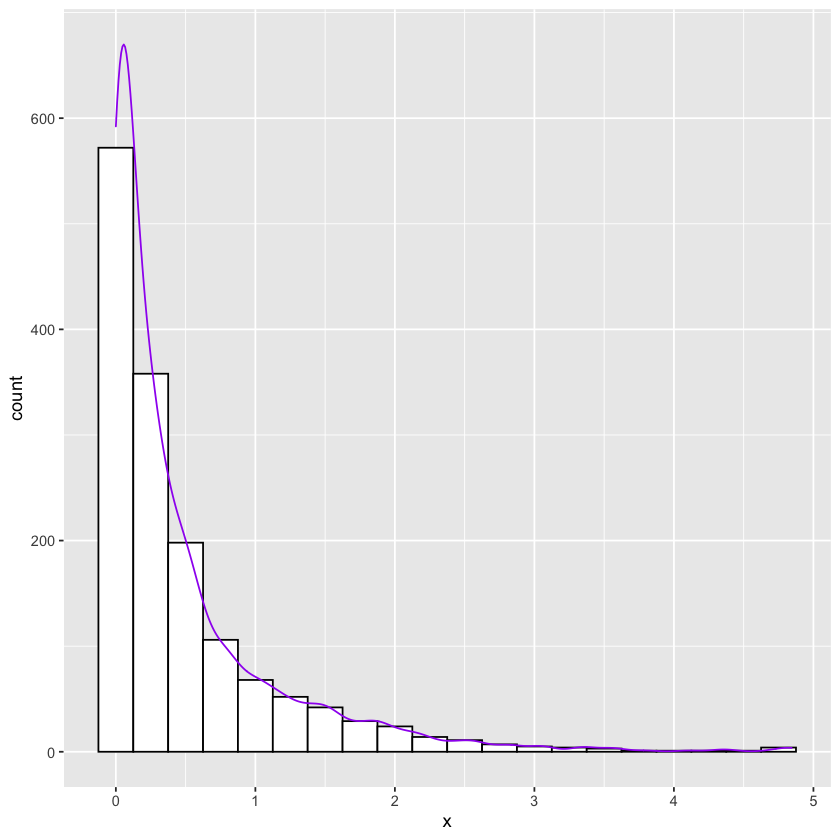

In [27]:
gamdata <- data.frame(x = x)
plt <- ggplot(gamdata, aes(x=x)) +  
    geom_histogram(binwidth=0.25, fill="white", color="black") + 
    geom_density(aes(y=0.25 * ..count..), color="purple")
print(plt)

## Multivariate random numbers

### Batch methods

#### Multinomial

Suppose we want to sample $(X_1, \dotsc, X_k) \sim \text{mult}(n, p_1, \dotsc, p_k)$, where $\sum_{i=1}^k p_i = 1$, $\sum_{i=1}^n X_i = n$.

* Method 1: draw $n$ independent realization from pmf $(p_1, \dotsc, p_k)$. 
    + An easy way is to declare category $j$, $j \in \{1, \dotsc, k\}$ if 
$$
    U \in \left[\sum_{k=0}^{j-1} p_k, \sum_{k=0}^{j} p_k \right),
$$
    where $U \sim \text{unif}[0, 1]$. Take $p_0 = 0$.
    
* Method 2: sample $k$ independent Poisson random variables $(X_1, \dotsc, X_k)$ with means $\lambda p_1, \dotsc, \lambda p_k$. If the total number of successes $\sum_{i=1}^k X_i$ is equal to $n$, then the conditional distribution of $(X_1, \dotsc, X_k)$ is the desired multinomial.
    + We must be fortunate for the sum to be exactly $n$.
    
#### Multivariate normal

Suppose we want to sample $\mathbf{X} = (X_1, \dotsc, X_p)$ from MVN $N(\boldsymbol{\mu}, \boldsymbol{\Sigma})$. If we can find $\mathbf{L} \in \mathbb{R}^{p \times p}$ such that $\mathbf{L}^T\mathbf{L} = \boldsymbol{\Sigma}$, then 
$$
    \mathbf{L}^T\mathbf{Z} + \boldsymbol{\mu}, \quad \mathbf{Z} \sim N(0, \mathbf{I}_p)
$$
follows the desired distribution.

* Random vector $\mathbf{Z}$ consists of $p$ independent standard normal random numbers.

* Possible choices of $\mathbf{L}$ are:

    + Cholesky decomposition of $\boldsymbol{\Sigma}$: $\mathbf{L}$ is lower triangular.
    + Matrix square root: if $\mathbf{Q}\boldsymbol{\Lambda}\mathbf{Q}^T$ is a eigenvalue decomposition of $\boldsymbol{\Sigma}$, where $\boldsymbol{\Lambda} = \text{diag}(\lambda_1, \dotsc, \lambda_p)$ with $\lambda_i \ge 0$, then
$$
    \mathbf{L} = \mathbf{Q}\boldsymbol{\Lambda}^{1/2}\mathbf{Q}^T,
    \quad
    \boldsymbol{\Lambda}^{1/2} = \text{diag}(\lambda_1^{1/2}, \dotsc, \lambda_p^{1/2})
    .
$$
such a matrix is symmetric and positive semidefinite, and is often denoted by $\boldsymbol{\Sigma}^{1/2}$.

* For large $p$, finding such a decomposition is challenging.

#### Multivariate $t$

A multivariate $t$ distribution with degrees of freedom $\nu$, scale matrix $\boldsymbol{\Sigma}$, and location vector $\boldsymbol{\mu}$ is the distribution of the random vector
$$
    \mathbf{T} = \frac{1}{\sqrt{\chi^2_{\nu}/\nu}}\mathbf{X} + \boldsymbol{\mu},
$$
where $\mathbf{X} \sim N(0, \boldsymbol{\Sigma})$, and $\chi^2_{\nu}$ is the chi-square random variable with $\nu$ degrees of freedom, independent of $\mathbf{X}$.

### Sequential sampling

In many cases we can sample a random vector by sampling each component in turn and conditioning:
\begin{align*}
    p_{X_1, \dotsc, X_p}(x_1, \dotsc, x_p) 
    &= p_{X_1}(x_1)\prod_{j=2}^p p_{X_j|X_1, \dotsc, X_{j-1}}(x_j | x_1, \dotsc, x_{j-1}) \\
    &= p_{X_1}(x_1)p_{X_2|X_1}(x_2|x_1) \prod_{j=3}^p p_{X_j|X_2, \dotsc, X_{j-1}}(x_j | x_1, \dotsc, x_{j-1}) \\
    &= \dotsb
\end{align*}

#### Multinomial

For $(X_1, \dotsc, X_k) \sim \text{mult}(n, p_1, \dotsc, p_k)$, it is immediate to see that $X_1 \sim B(n, p_1)$. Given $X_1 = x_1$, $(X_2, \dotsc, X_k) \sim \text{mult}(n - x_1, p_2 / (1 - p_1), \dotsc, p_k / (1 - p_1) )$. Hence $X_2 | \{X_1 = x_1\} \sim B(n - x_1, p_2 / (1 - p_1) )$ and so on.

#### Multivariate normal

If we want to sample $\mathbf{X} = (X_1, \dotsc, X_p)$ from MVN with mean $\boldsymbol{\mu}=(\mu_1, \dotsc, \mu_p)^T$ and covariance matrix $\boldsymbol{\Sigma} = (\sigma_{ij})$, then note that the first component $X_1 \sim N(\mu_1, \sigma_{11})$. From the conditional distribution formula for multivariate normal, we see that
$$
    (X_2, \dotsc, X_p) | \{X_1 = x_1\}
    \sim N(\bar{\boldsymbol{\mu}}, \bar{\boldsymbol{\Sigma}}),
    \quad
    \bar{\boldsymbol{\mu}} = \boldsymbol{\mu}_2 + \boldsymbol{\Sigma}_{12}^T(x_1 - \mu_1)/\sigma_{11},
    ~
    \bar{\boldsymbol{\Sigma}} = \boldsymbol{\Sigma}_{22} - \boldsymbol{\Sigma}_{12}^T\boldsymbol{\Sigma}_{12}/\sigma_{11}
$$
if we partition
\begin{align*}
    \boldsymbol{\mu} &= (\mu_1, \boldsymbol{\mu}_2)^T \\
    \boldsymbol{\Sigma} &= \begin{bmatrix}
        \sigma_{11} & \boldsymbol{\Sigma}_{12} \\
        \boldsymbol{\Sigma}_{12}^T & \boldsymbol{\Sigma}_{22}
        \end{bmatrix}  
     .
\end{align*}